# Homework 1: Alexandre LANDEAU et Vivien ROBERT

## Setup & Libraries

In [1]:
#Before the analysis you should have installed the packages needed
#pip3 install yahoo-finance
from pandas_datareader import data
import matplotlib.pyplot as plt
import pandas as pd
import datetime
import math
import numpy as np
from scipy import stats
from scipy.stats import norm
import seaborn as sns
import bs4 as bs
import pickle
import requests
import fix_yahoo_finance as yf
import string
import scipy.stats as stats

In [2]:
%matplotlib inline 
sns.set()
yf.pdr_override()

## Download the data

In [3]:
stocks_list = []

Create a Scrapper to get the list of all S&P500 companies from wikipedia

In [10]:
def save_sp500_tickers():
    resp = requests.get('http://en.wikipedia.org/wiki/List_of_S%26P_500_companies')
    soup = bs.BeautifulSoup(resp.text, 'lxml')
    table = soup.find('table', {'class': 'wikitable sortable'})
    tickers = []
    for row in table.findAll('tr')[1:]:
        ticker = row.findAll('td')[1].text
        tickers.append(ticker)
        
    with open("sp500tickers.pickle","wb") as f:
        pickle.dump(tickers,f)
        
    return tickers

stocks = save_sp500_tickers()

In [2]:
stocks

NameError: name 'stocks' is not defined

In [13]:
# Replace dots with hyphen to correct incompatibility between Wikipedia and Yahoo! Finance API

stocks = [stock.replace('.', '-') for stock in stocks]
stocks.append('^GSPC')

In [1]:
# We would like all available data from 03/01/2007 until today.
start_date = '1900-01-01'
end = datetime.date.today()

def get_stocks_data(ticker, source):
    # User pandas_reader.data.DataReader to load the desired data. As simple as that.
    Ticker = data.DataReader(ticker, source, start_date, end)
    Ticker['Ticker'] = ticker
    return Ticker
    
stocks_data = [get_stocks_data(ticker, 'yahoo') for ticker in stocks]

NameError: name 'datetime' is not defined

In [14]:
stocks_data = pd.concat(stocks_data, axis=0)
stocks_data = stocks_data.set_index(['Ticker'], append=True)
stocks_data.head()

NameError: name 'stocks_data' is not defined

## Non-parametric estimates of mean, std, skewness & kurtosis

In [12]:
stock_data=stocks_data

In [13]:
def log_stock_return(data):
    # Log the prices
    data["Log"] = np.log(data["Adj Close"])
    # Compute the difference
    data["Returns"] = data.groupby(by="Ticker")["Adj Close"].diff()
    # Fill the NA values with the stock return mean 
    data["Returns"] = data.groupby(by="Ticker")["Returns"].apply(lambda x: x.fillna(x.mean()))
    return data
def compute_statistics(data):
    return data.groupby(by="Ticker")["Returns"].agg({"statistics": [np.mean, np.std,stats.skew,stats.kurtosis]})
def plot_density(data, stat):
    d=stats.gaussian_kde(data[stat])
    if stat == 'mean':
        ind = np.linspace(-0.5,0.5,500)
    elif stat == 'kurtosis':
        ind = np.linspace(-150,200,500)
    else:
        ind = np.linspace(-20,20,500)
    kdepdf = d.evaluate(ind)
    #plt.figure(figsize=(10,8))
    # plot histgram of sample
    plt.plot(ind, stats.norm.pdf(ind, loc = np.mean(data[stat]), scale = np.std(data[stat])), color="r", label='DGP normal')
    # plot estimated density
    label = '{} kde'.format(stat)
    plt.plot(ind, kdepdf, label=label, color="g")
    plt.title('Empirical {} density vs Gaussian'.format(stat))

In [14]:
# Compute the log_stock_return
return_data = log_stock_return(stock_data)
# Create the matrix with mean, std, skewness and kurtosis
statistics_matrix = compute_statistics(return_data)
# Drop the level "statistics"
statistics_matrix.columns = statistics_matrix.columns.droplevel()

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in log
  This is separate from the ipykernel package so we can avoid doing imports until
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  # Remove the CWD from sys.path while we load stuff.


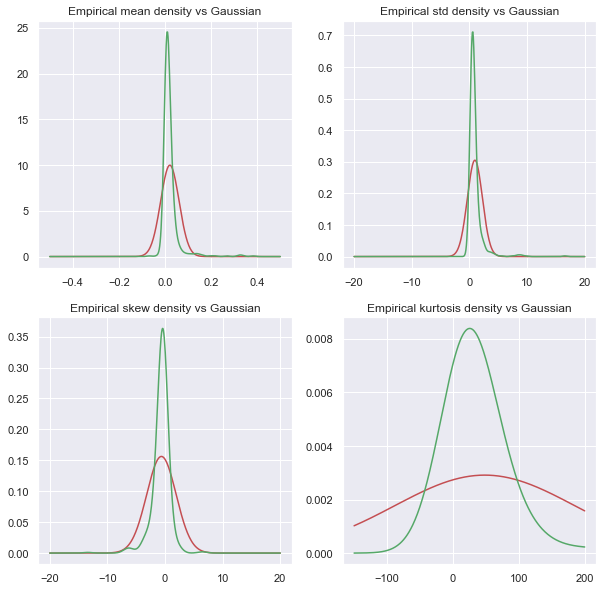

In [15]:
# Plot the 4 density estimates
plt.figure(figsize=(10, 10))

stats_to_plot = ['mean', 'std', 'skew', 'kurtosis']

for i in range(4):
    plt.subplot(2, 2, i+1)
    plot_density(statistics_matrix, stats_to_plot[i])

plt.show()

Conclusion: we can see that the 4 metrics are not following normal distributions based on the mean and standard deviation of the samples. They tend to follow distributions which are not exactly centered on the same values and have much squeezed center parts and thus, larger tails which emphasizes the higher probability of extreme values than the common normal distribution.
The mean, std, skewness and kurtosis of the log returns have more extreme values than the common normal distribution.

## Non-parametric estimates of stock return correlation with S&P 500

In [16]:
def compute_corrcoeff(data):
    corr_data = data.reset_index(level="Ticker")
    corr_data = corr_data[["Ticker","Returns"]].pivot(columns="Ticker")
    return corr_data.corr().iloc[:,-1]

def plot_density_corr(data):
    d=stats.gaussian_kde(data)
    ind = np.linspace(-1,2,500)
    kdepdf = d.evaluate(ind)
    plt.plot(ind, stats.norm.pdf(ind, loc = np.mean(data), scale = np.std(data)), color="r", label='DGP normal')
    # plot estimated density
    label = "S&P 500 correlation density estimate"
    plt.plot(ind, kdepdf, label=label, color="g")
    plt.title('Empirical S&P 500 Correlation density vs Gaussian')



In [17]:
SP_500_corr = compute_corrcoeff(return_data)

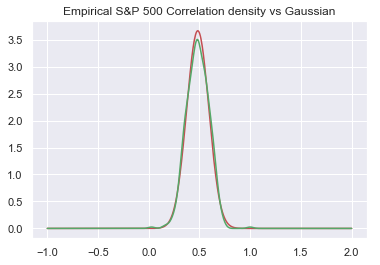

In [18]:
# Non parametric density estimate of stoch returns correlation with S&P 500
plot_density_corr(SP_500_corr)
plt.show()

Conclusion: The distribution of the log stock returns correlation seems to be close to a normal distribution with slightly larger tails than the Gaussian. On average, the companies'stock returns are positively correlated with the S&P 500 returns. (correlation is on average close to +0.5).

## Focus period previous to 2007

In [19]:
def get_date_window(data,start_date, end_date):
    data = data.copy()
    data.sort_index(level=['Date','Ticker'], ascending=[True, False], inplace=True)
    if start_date==None:
        stock_data_date= data.loc[pd.IndexSlice[:"2007-01-01",],:].copy()
    else:
        stock_data_date= data.loc[pd.IndexSlice[start_date:,],:].copy()
    return stock_data_date

In [20]:
stock_data_2007 = get_date_window(stock_data,start_date=None, end_date="2007-01-01")

In [21]:
# Compute the log_stock_return before 2007
return_data_2007 = log_stock_return(stock_data_2007)
# Create the matrix with mean, std, skewness and kurtosis before 2007
statistics_matrix_2007 = compute_statistics(return_data_2007)
# Drop the level "statistics"
statistics_matrix_2007.columns = statistics_matrix_2007.columns.droplevel()

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in log
  This is separate from the ipykernel package so we can avoid doing imports until
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  # Remove the CWD from sys.path while we load stuff.


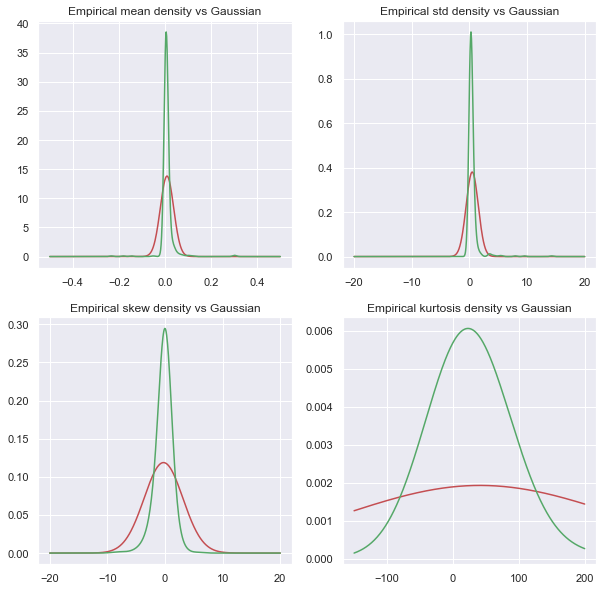

In [22]:
# Plot the 4 density estimates
plt.figure(figsize=(10, 10))

stats_to_plot = ['mean', 'std', 'skew', 'kurtosis']

for i in range(4):
    plt.subplot(2, 2, i+1)
    plot_density(statistics_matrix_2007, stats_to_plot[i])

plt.show()

In [23]:
SP_500_corr_2007 = compute_corrcoeff(return_data_2007)

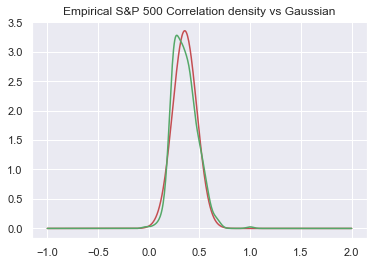

In [24]:
# Non parametric density estimate of stoch returns correlation with S&P 500 before 2007
plot_density_corr(SP_500_corr_2007)
plt.show()

Conclusion: before 2007, the correlation with the S&P 500 stock returns density is significantly different from the normal distribution.

## Focus period after 2009


In [25]:
stock_data_2009 = get_date_window(stock_data,start_date="2009-01-01", end_date=None)

In [26]:
# Compute the log_stock_return after 2009
return_data_2009 = log_stock_return(stock_data_2009)
# Create the matrix with mean, std, skewness and kurtosis after 2009
statistics_matrix_2009 = compute_statistics(return_data_2009)
# Drop the level "statistics"
statistics_matrix_2009.columns = statistics_matrix_2009.columns.droplevel()

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  # Remove the CWD from sys.path while we load stuff.


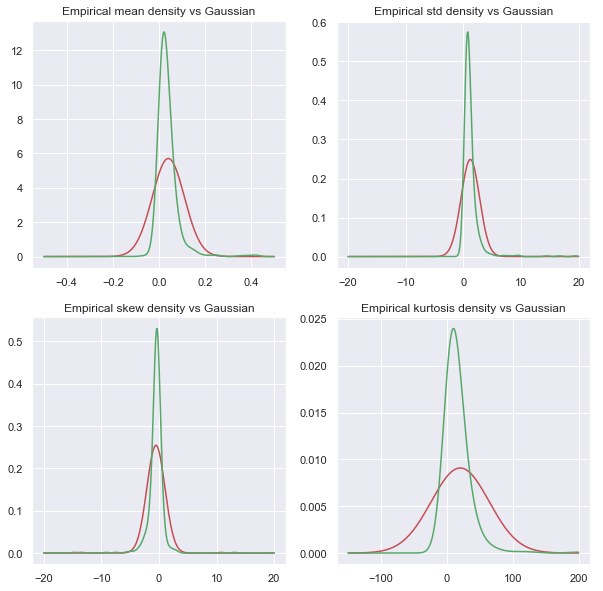

In [27]:
# Plot the 4 density estimates
plt.figure(figsize=(10, 10))

stats_to_plot = ['mean', 'std', 'skew', 'kurtosis']

for i in range(4):
    plt.subplot(2, 2, i+1)
    plot_density(statistics_matrix_2009, stats_to_plot[i])

plt.show()

In [28]:
SP_500_corr_2009 = compute_corrcoeff(return_data_2009)

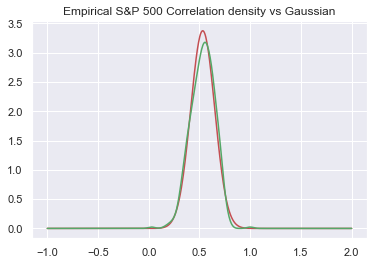

In [29]:
# Non parametric density estimate of stoch returns correlation with S&P 500 after 2009
plot_density_corr(SP_500_corr_2009)
plt.show()

Conclusion: when comparing before 2007 and after 2009 density distributions, one can observe:
- after 2009, the mean distribution seems to be centered on a higer value than before 2007, to have a larger center part and to be more right-skewed. There are less extreme values in the mean return and on average, the mean returns are HIGHER than before 2007.
- after 2009, the std distribution has larger center part and is more right skewed. There are thus less extreme values but with on average larger standard deviation / volatility.


It seems that post 2009 is a new era with high mean returns on average but more uncertainty and volatility

## Kolmogorov Smirnof Test (before 2007 versus after 2009)

In [30]:
def compute_ks_test(data1,data2):
    return stats.ks_2samp(data1, data2)

In [31]:
# Compute the Kolmogorov test between before 2007 and after 2009 statistics

# for the correlation with the S&P 500, we can largely reject the null hypothesis
# Consequently, the 2 samples are NOT  drawn from the same distribution!
compute_ks_test(SP_500_corr_2009,SP_500_corr_2007)

Ks_2sampResult(statistic=0.565929565929566, pvalue=2.631837346209838e-67)

In [32]:
# For the 4 statistics (mean, std, skewness, kurtosis)

# Mean: we can reject the null hypothesis
print(compute_ks_test(statistics_matrix_2009["mean"],statistics_matrix_2007["mean"]))
# std: we can reject the null hypothesis
print(compute_ks_test(statistics_matrix_2009["std"],statistics_matrix_2007["std"]))
# skewness: we can reject the null hypothesis
print(compute_ks_test(statistics_matrix_2009["skew"],statistics_matrix_2007["skew"]))
# kurtosis: we can reject the null hypothesis
print(compute_ks_test(statistics_matrix_2009["kurtosis"],statistics_matrix_2007["kurtosis"]))

# Consequently, the 2 samples are drawn from DIFFERENT distributions!

Ks_2sampResult(statistic=0.6040843214756259, pvalue=1.2534491031853058e-76)
Ks_2sampResult(statistic=0.599250436206958, pvalue=2.054847021245074e-75)
Ks_2sampResult(statistic=0.2966830466830466, pvalue=8.324027195977936e-19)
Ks_2sampResult(statistic=0.29200049852223764, pvalue=3.1329958784073107e-18)


Conclusion: there is no stability over time. The 2 samples (before 2007 and after 2009) are drawn from totally different Probability Density functions which emphasizes the huge impact of the financial crisis on the financial markets. There is clearly an "after financial crisis" effect